In [1725]:
import numpy as np
import pandas as pd
import tqdm
import pickle
from sympy import plot_implicit, Eq, symbols, exp
import matplotlib.pyplot as plt
import random
from sklearn.metrics import confusion_matrix
from mpl_toolkits import mplot3d
from itertools import product
from pandas import DataFrame
%matplotlib inline
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
from sklearn import svm,mixture
from IPython.display import Image, display
from scipy.stats import multivariate_normal

# Question 1

## Generate data

In [38]:
np.random.seed(223)

In [39]:
x_train = np.random.gamma(3,2,1000)
x_test = np.random.gamma(3,2,10000)

In [40]:
z_train = np.exp((x_train**2) * np.exp(-x_train/2))
z_test = np.exp((x_test**2) * np.exp(-x_test/2))

In [41]:
v_train = np.random.lognormal(0,0.1,1000)
v_test  = np.random.lognormal(0,0.1,10000)

In [42]:
y_train = v_train * z_train
y_test = v_test * z_test

In [47]:
x_train = x_train[:,np.newaxis]
y_train = y_train[:,np.newaxis]
x_test = x_test[:,np.newaxis]
y_test = y_test[:,np.newaxis]

Text(0.5, 1.0, 'Training data distribution')

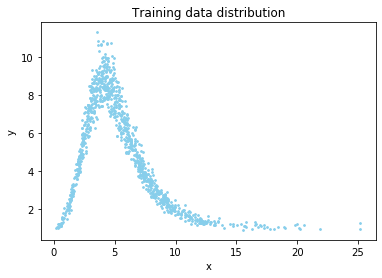

In [48]:
plt.scatter(x_train, y_train, s = 3, c = 'skyblue')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Training data distribution')

Text(0.5, 1.0, 'Test data distribution')

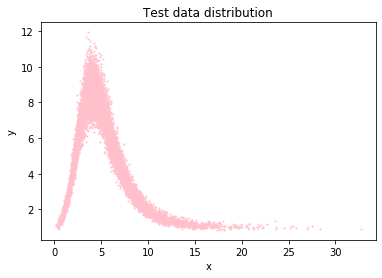

In [49]:
plt.scatter(x_test, y_test, s = 1, c = 'pink')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Test data distribution')

## MLP Structure

In [742]:
class MyMLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MyMLP, self).__init__()
        
        self.input_hidden = nn.Linear(input_size, hidden_size, bias=True)
        self.hidden_output = nn.Linear(hidden_size, output_size, bias=True)
        
    def forward(self, data):

        z = self.input_hidden(data)
        a = torch.tanh(z)
        
        z2 = self.hidden_output(a)
        # output = torch.log(1 + torch.exp(z2))
        output = z2
        
        return output
    
def train_one_epoch(model, data, gt):
    
    model.train()
    model.zero_grad()
    prediction = model(data).squeeze(-1)
    loss = nn.MSELoss()
    output = loss(prediction,gt)
    return output,prediction

def validation(model, data, gt):
    
    model.eval()
    with torch.no_grad():
        prediction = model(data).squeeze(-1)
        loss = nn.MSELoss()
        output = loss(prediction,gt)
    return output

In [728]:
test_model = MyMLP(1,3,1)

In [729]:
x = torch.tensor(x_test, dtype=torch.float32)
y = torch.tensor(y_test, dtype=torch.float32)

## Model order selection

In [743]:
def k_fold(dataset, label, k):
    data_size = len(dataset)
    step = data_size // k
    index = np.arange(k) * step
    for i in range(k):
        val_index = np.arange(index[i], index[i] + step)
        train_index = list(set(range(data_size)).difference(val_index))
        yield dataset[train_index], dataset[val_index], label[train_index], label[val_index]

In [744]:
def model_order_selection(dataset, label):   
    
    MSE_result = dict()
    for num_node in range(1,21):
        print('calculate...... num_node = {}'.format(num_node))
        
        dataAndlabel = [(train, val, train_label, val_label, i) for i,
                        (train, val, train_label, val_label) in enumerate(k_fold(dataset, label, 10))]
        
        MSE_list = list()
        for j in range (0,10):
            model = MyMLP(1, num_node, 1)
            optimizer = torch.optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08)
            schedular = torch.optim.lr_scheduler.StepLR(optimizer, 20, gamma=0.95, verbose=False)

            train_data = torch.tensor(np.array(dataAndlabel)[j,0], dtype=torch.float32)
            val_data = torch.tensor(np.array(dataAndlabel)[j,1], dtype=torch.float32)
            train_gt = torch.tensor(np.array(dataAndlabel)[j,2], dtype=torch.float32)
            val_gt = torch.tensor(np.array(dataAndlabel)[j,3], dtype=torch.float32)

            epochs = 1000
            train_loss_list = list()
            val_loss_list = list()
            min_val_loss = 0

            for epoch in range(epochs):
                train_loss,_ = train_one_epoch(model, train_data, train_gt)
                train_loss_list.append(train_loss.detach())
    
                train_loss.backward() ## calculate gradients
                optimizer.step()  ## optimize parameters
                schedular.step()  ## optimize learning rate
    
                val_loss = validation(model, val_data, val_gt)
                val_loss_list.append(val_loss)
                if len(val_loss_list) == 1:
                    min_val_loss = val_loss
                    continue
                elif val_loss > val_loss_list[-2]:
                    break 
                else: 
                    min_val_loss = val_loss
                
            MSE_list.append(min_val_loss)
        MSE_result[num_node] = (np.array(MSE_list).mean(), np.array(MSE_list).min(), np.array(MSE_list).max())
      
       
    return MSE_result

In [745]:
MSE_result = model_order_selection(x_train, y_train)

calculate...... num_node = 1
calculate...... num_node = 2
calculate...... num_node = 3
calculate...... num_node = 4
calculate...... num_node = 5
calculate...... num_node = 6
calculate...... num_node = 7
calculate...... num_node = 8
calculate...... num_node = 9
calculate...... num_node = 10
calculate...... num_node = 11
calculate...... num_node = 12
calculate...... num_node = 13
calculate...... num_node = 14
calculate...... num_node = 15
calculate...... num_node = 16
calculate...... num_node = 17
calculate...... num_node = 18
calculate...... num_node = 19
calculate...... num_node = 20


In [746]:
MSE = np.array([v[0] for v in MSE_result.values()])
MSE_min = np.array([v[1] for v in MSE_result.values()])
MSE_max = np.array([v[2] for v in MSE_result.values()])

Text(0, 0.5, 'Mean Square error')

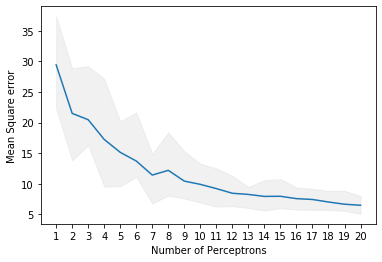

In [2050]:
plt.plot(range(1,21), MSE)
plt.fill_between(range(1,21), MSE_min, MSE_max, color='lightgrey', alpha=0.3)
plt.xlabel('Number of Perceptrons')
plt.xticks(np.arange(1,21,1))
plt.ylabel('Mean Square error')

In [748]:
select_num_node = MSE.argmin() + 1

In [749]:
MSE

array([29.43785  , 21.508085 , 20.472708 , 17.245611 , 15.138367 ,
       13.722531 , 11.42304  , 12.196545 , 10.435167 ,  9.904055 ,
        9.210874 ,  8.449931 ,  8.260228 ,  7.934813 ,  7.957202 ,
        7.5697837,  7.4334364,  7.0175843,  6.6589136,  6.4891977],
      dtype=float32)

In [750]:
select_num_node

20

## Model Training and assessment

In [755]:
def model_train_assessment(trainData, trainValue, testData, testValue, num_node):
    model = MyMLP(1, num_node, 1)
    optimizer = torch.optim.Adam(model.parameters(), lr = 0.01, betas=(0.9, 0.999), eps=1e-08)
    schedular = torch.optim.lr_scheduler.StepLR(optimizer, 20, gamma=0.95, verbose=False)
    
    train_data = torch.tensor(trainData, dtype=torch.float32)
    test_data = torch.tensor(testData, dtype=torch.float32)
    train_value = torch.tensor(trainValue, dtype=torch.float32)
    test_value = torch.tensor(testValue, dtype=torch.float32)
    
    epochs = 1000
    train_loss_list = list()
 
    for epoch in range(epochs):
        train_loss,_ = train_one_epoch(model, train_data, train_value)
        print(train_loss)
        train_loss_list.append(train_loss.detach())
        train_loss.backward() ## calculate gradients
        optimizer.step()  ## optimize parameters
        schedular.step()  ## optimize learning rate
    
    #loss,prediction = train_one_epoch(model, train_data, train_value)
    model.eval()
    with torch.no_grad():
        prediction = model(test_data)
    MSE = ((prediction.numpy() - testValue)**2).mean()
    return prediction, MSE

In [2060]:
prediction,MSE_evaluation = model_train_assessment(x_train, y_train, x_test, y_test,20)

tensor(31.9656, grad_fn=<MseLossBackward>)
tensor(29.9705, grad_fn=<MseLossBackward>)
tensor(28.0696, grad_fn=<MseLossBackward>)
tensor(26.2636, grad_fn=<MseLossBackward>)
tensor(24.5492, grad_fn=<MseLossBackward>)
tensor(22.9235, grad_fn=<MseLossBackward>)
tensor(21.3850, grad_fn=<MseLossBackward>)
tensor(19.9324, grad_fn=<MseLossBackward>)
tensor(18.5646, grad_fn=<MseLossBackward>)
tensor(17.2811, grad_fn=<MseLossBackward>)
tensor(16.0818, grad_fn=<MseLossBackward>)
tensor(14.9670, grad_fn=<MseLossBackward>)
tensor(13.9368, grad_fn=<MseLossBackward>)
tensor(12.9910, grad_fn=<MseLossBackward>)
tensor(12.1289, grad_fn=<MseLossBackward>)
tensor(11.3490, grad_fn=<MseLossBackward>)
tensor(10.6490, grad_fn=<MseLossBackward>)
tensor(10.0265, grad_fn=<MseLossBackward>)
tensor(9.4783, grad_fn=<MseLossBackward>)
tensor(9.0008, grad_fn=<MseLossBackward>)
tensor(8.5903, grad_fn=<MseLossBackward>)
tensor(8.2587, grad_fn=<MseLossBackward>)
tensor(7.9801, grad_fn=<MseLossBackward>)
tensor(7.7503, g

tensor(2.9583, grad_fn=<MseLossBackward>)
tensor(2.9373, grad_fn=<MseLossBackward>)
tensor(2.9163, grad_fn=<MseLossBackward>)
tensor(2.8953, grad_fn=<MseLossBackward>)
tensor(2.8744, grad_fn=<MseLossBackward>)
tensor(2.8537, grad_fn=<MseLossBackward>)
tensor(2.8329, grad_fn=<MseLossBackward>)
tensor(2.8123, grad_fn=<MseLossBackward>)
tensor(2.7917, grad_fn=<MseLossBackward>)
tensor(2.7712, grad_fn=<MseLossBackward>)
tensor(2.7508, grad_fn=<MseLossBackward>)
tensor(2.7305, grad_fn=<MseLossBackward>)
tensor(2.7102, grad_fn=<MseLossBackward>)
tensor(2.6901, grad_fn=<MseLossBackward>)
tensor(2.6700, grad_fn=<MseLossBackward>)
tensor(2.6500, grad_fn=<MseLossBackward>)
tensor(2.6301, grad_fn=<MseLossBackward>)
tensor(2.6102, grad_fn=<MseLossBackward>)
tensor(2.5905, grad_fn=<MseLossBackward>)
tensor(2.5708, grad_fn=<MseLossBackward>)
tensor(2.5513, grad_fn=<MseLossBackward>)
tensor(2.5328, grad_fn=<MseLossBackward>)
tensor(2.5144, grad_fn=<MseLossBackward>)
tensor(2.4960, grad_fn=<MseLossBac

tensor(0.5619, grad_fn=<MseLossBackward>)
tensor(0.5605, grad_fn=<MseLossBackward>)
tensor(0.5591, grad_fn=<MseLossBackward>)
tensor(0.5577, grad_fn=<MseLossBackward>)
tensor(0.5564, grad_fn=<MseLossBackward>)
tensor(0.5550, grad_fn=<MseLossBackward>)
tensor(0.5537, grad_fn=<MseLossBackward>)
tensor(0.5523, grad_fn=<MseLossBackward>)
tensor(0.5510, grad_fn=<MseLossBackward>)
tensor(0.5497, grad_fn=<MseLossBackward>)
tensor(0.5484, grad_fn=<MseLossBackward>)
tensor(0.5470, grad_fn=<MseLossBackward>)
tensor(0.5458, grad_fn=<MseLossBackward>)
tensor(0.5445, grad_fn=<MseLossBackward>)
tensor(0.5432, grad_fn=<MseLossBackward>)
tensor(0.5420, grad_fn=<MseLossBackward>)
tensor(0.5408, grad_fn=<MseLossBackward>)
tensor(0.5396, grad_fn=<MseLossBackward>)
tensor(0.5384, grad_fn=<MseLossBackward>)
tensor(0.5372, grad_fn=<MseLossBackward>)
tensor(0.5360, grad_fn=<MseLossBackward>)
tensor(0.5349, grad_fn=<MseLossBackward>)
tensor(0.5337, grad_fn=<MseLossBackward>)
tensor(0.5325, grad_fn=<MseLossBac

tensor(0.3996, grad_fn=<MseLossBackward>)
tensor(0.3994, grad_fn=<MseLossBackward>)
tensor(0.3993, grad_fn=<MseLossBackward>)
tensor(0.3991, grad_fn=<MseLossBackward>)
tensor(0.3990, grad_fn=<MseLossBackward>)
tensor(0.3988, grad_fn=<MseLossBackward>)
tensor(0.3987, grad_fn=<MseLossBackward>)
tensor(0.3985, grad_fn=<MseLossBackward>)
tensor(0.3984, grad_fn=<MseLossBackward>)
tensor(0.3982, grad_fn=<MseLossBackward>)
tensor(0.3981, grad_fn=<MseLossBackward>)
tensor(0.3979, grad_fn=<MseLossBackward>)
tensor(0.3978, grad_fn=<MseLossBackward>)
tensor(0.3976, grad_fn=<MseLossBackward>)
tensor(0.3975, grad_fn=<MseLossBackward>)
tensor(0.3973, grad_fn=<MseLossBackward>)
tensor(0.3972, grad_fn=<MseLossBackward>)
tensor(0.3971, grad_fn=<MseLossBackward>)
tensor(0.3969, grad_fn=<MseLossBackward>)
tensor(0.3968, grad_fn=<MseLossBackward>)
tensor(0.3966, grad_fn=<MseLossBackward>)
tensor(0.3965, grad_fn=<MseLossBackward>)
tensor(0.3964, grad_fn=<MseLossBackward>)
tensor(0.3962, grad_fn=<MseLossBac

In [2061]:
pred = prediction.numpy()

Text(0.5, 1.0, 'Actual data Vs Estimated data with MSE = 0.393')

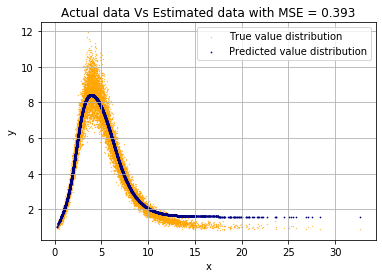

In [2062]:
plt.scatter(x_test, y_test, s = 0.1, c = 'orange',label = 'True value distribution')
plt.scatter(x_test, pred, s = 0.5, c = 'Navy',label = 'Predicted value distribution')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.grid()
plt.title('Actual data Vs Estimated data with MSE = {}'.format(MSE_evaluation.round(3)))

# Question 2

## Generate data

In [980]:
np.random.seed(223)

In [981]:
def data_generation(num_class, num_sample):
    thr = np.linspace(0,1,num_class+1)
    uniform_samples = np.random.rand(num_sample, 1)
    labels = np.zeros([num_sample,1])
    for l in range(0,num_class):
        ind_l = (thr[l]<uniform_samples)&(thr[l+1]>=uniform_samples)
        labels[ind_l] = l
    a = list()
    for i in range(1,num_class+1):
        a.append(i**2.5)
    b = np.ones((num_class,1)) * 1.7
    angle = np.random.rand(num_sample,1)*2*np.pi
    radius = np.zeros((num_sample,1))
    for l in range(0,num_class):
        ind_l = (labels == l)
        radius[ind_l] = np.random.gamma(a[l],b[l],ind_l.sum())
    data = np.random.rand(num_sample,2)
    data[:,0][:,np.newaxis] = radius * np.cos(angle)
    data[:,1][:,np.newaxis] = radius * np.sin(angle)
    
    return data,labels

In [982]:
train_data,train_labels = data_generation(2,1000)

In [983]:
test_data,test_labels = data_generation(2,10000)

Text(0.5, 1.0, 'Training set')

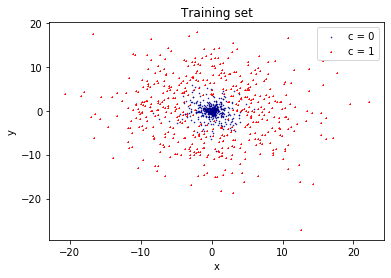

In [984]:
plt.scatter(train_data[:,0][:,np.newaxis][train_labels==0],
            train_data[:,1][:,np.newaxis][train_labels==0], 
            s = 1,c = 'darkblue',marker = '.',label = 'c = 0')
plt.scatter(train_data[:,0][:,np.newaxis][train_labels==1],
            train_data[:,1][:,np.newaxis][train_labels==1], 
            s = 1,c = 'red',marker = '+', label = 'c = 1')
plt.legend()
plt.xlabel('x')
plt.ylabel('y')
plt.title('Training set')

Text(0.5, 1.0, 'Test set')

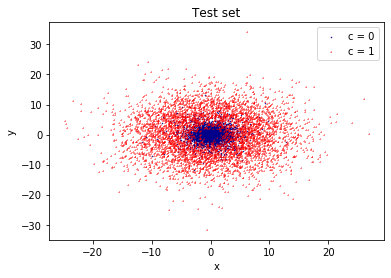

In [985]:
plt.scatter(test_data[:,0][:,np.newaxis][test_labels==0],
            test_data[:,1][:,np.newaxis][test_labels==0], 
            s = 1,c = 'darkblue',marker = '.',label = 'c = 0')
plt.scatter(test_data[:,0][:,np.newaxis][test_labels==1],
            test_data[:,1][:,np.newaxis][test_labels==1], 
            s = 1,c = 'red',marker = '+', label = 'c = 1', alpha = 0.5)
plt.legend()
plt.xlabel('x')
plt.ylabel('y')
plt.title('Test set')

## Train and evaluate model

In [1018]:
clf = svm.SVC(C=1000,gamma=1000)
clf.fit(train_data, train_labels.reshape(1000,))

SVC(C=1000, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=1000, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [1095]:
c_range = np.logspace(-2, 5, 8)

In [1096]:
gamma_range = np.logspace(-4, 3, 8)

In [1283]:
def model_train(data,label):
    Result = {}
    for c in c_range:
        for gamma in gamma_range:
            name = '{}+{}'.format(c,gamma)
            classifiers = []
            dataAndlabel = [(train, val, train_label, val_label, i) for i,
                            (train, val, train_label, val_label) in enumerate(k_fold(data, label, 10))]
            for j in range(0,10):
                train_data = dataAndlabel[j][0]
                val_data = dataAndlabel[j][1]
                train_gt = dataAndlabel[j][2]
                val_gt = dataAndlabel[j][3]
                
                ## Train
                clf = svm.SVC(C = c,gamma = gamma)
                clf.fit(train_data, train_gt.reshape(train_gt.shape[0],))
                
                ## Evaluate
                accuracy = ((clf.predict(val_data))[:,np.newaxis] == val_gt).mean()
                
                classifiers.append((c,gamma,clf,accuracy))
            Result[name] = classifiers

    return Result

In [1284]:
result = model_train(train_data,train_labels)

In [1285]:
name_list = []
for c in c_range:
        for gamma in gamma_range:
            name_list.append('{}+{}'.format(c,gamma))

In [1286]:
avg_acc_list = []
for i in range(0,len(name_list)):
    accuracy_list = []
    for j in range(0,10):
        accuracy_list.append(result[name_list[i]][j][3])
        avg_acc = np.array(accuracy_list).mean()  
    avg_acc_list.append(avg_acc)

In [1287]:
best_pair_c_gamma = np.array(name_list)[np.array(avg_acc_list).argmax()]

In [1288]:
## Train the model with the best pair parameters using the entire training data
best_model = svm.SVC(C = 1,gamma = 0.01)
best_model.fit(train_data, train_labels.reshape(train_labels.shape[0],))

SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [1289]:
acc_eval= ((best_model.predict(test_data))[:,np.newaxis] 
           == test_labels).mean()

In [1290]:
acc_eval

0.9193

In [1291]:
best_model

SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

## Result report and visaulization

In [1292]:
compare_model_name =[('0.01+0.0001'),('0.01+0.01'),('0.01+1.0'),('0.01+10.0'),
                     ('1.0+0.0001'),('1.0+0.01'),('1.0+1.0'),('1.0+10.0'),
                     ('100.0+0.0001'),('100.0+0.01'),('100.0+1.0'),('100.0+10.0'),
                     ('1000.0+0.0001'),('1000.0+0.01'),('1000.0+1.0'),('1000.0+10.0')]

In [1293]:
# select the best model from 10-fold for each pair of parameters
def select_best_model(compare_model_name,result):
    compare_model = []
    for parameter_num in compare_model_name:
        acc_list = []
        for i in range(0,10):
            acc_list.append(result[parameter_num][i][3])
        select_model = result[parameter_num][np.array(acc_list).argmax()]
        compare_model.append(select_model)
    return compare_model

In [1294]:
compare_model = select_best_model(compare_model_name,result)

/Users/tmac/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: No contour levels were found within the data range.
  app.launch_new_instance()
/Users/tmac/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: No contour levels were found within the data range.
  app.launch_new_instance()


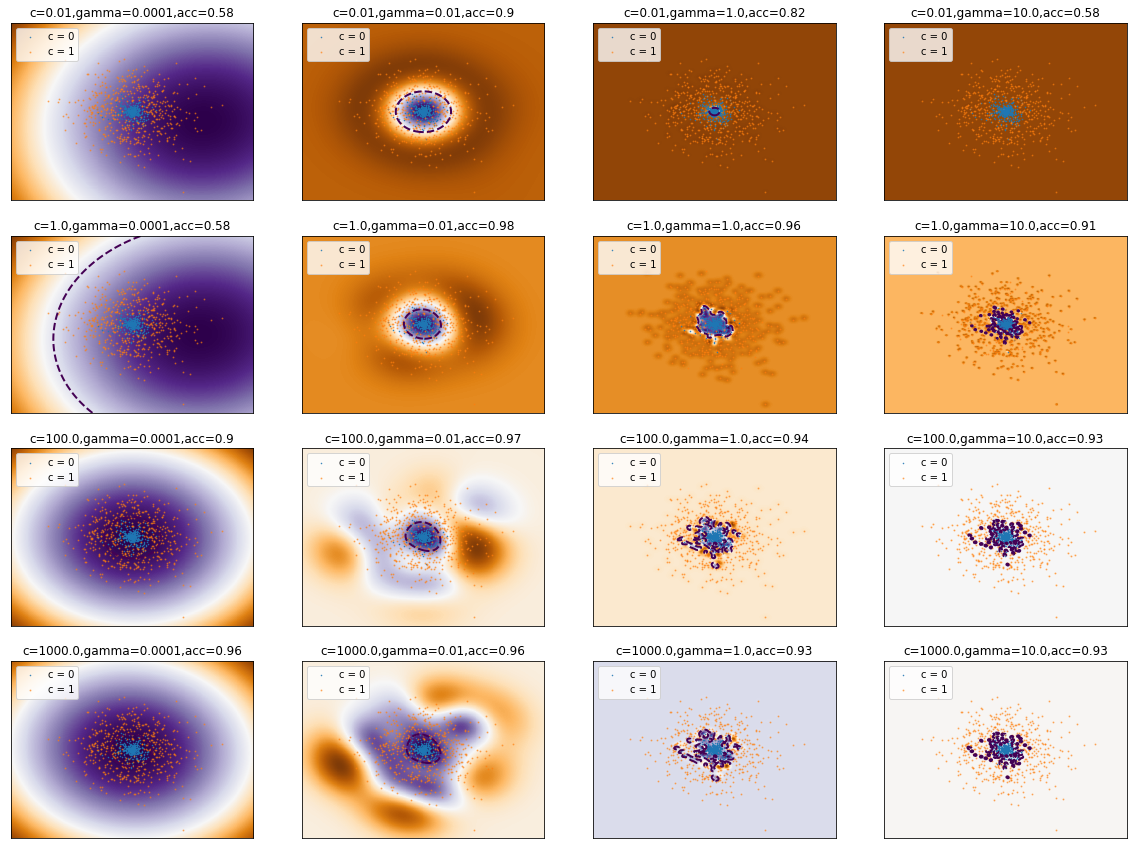

In [1295]:
plt.figure(figsize=(20, 15))
xx, yy = np.meshgrid(np.linspace(-30, 30, 500),
                     np.linspace(-30, 30, 500))

for (k, (c, gamma, clf, accuracy)) in enumerate(compare_model):
    Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    plt.subplot(4, 4, k + 1)
    plt.title('c={},gamma={},acc={}'.format(c,gamma,accuracy))
    
    plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()), aspect='auto',
           origin='lower', cmap=plt.cm.PuOr_r)
    contours = plt.contour(xx, yy, Z, levels=[0], linewidths=2,
                       linestyles='dashed')
    plt.scatter(train_data[:,0][:,np.newaxis][train_labels==0],
            train_data[:,1][:,np.newaxis][train_labels==0], 
            s = 1,marker = '.',label = 'c = 0',
            cmap=plt.cm.Paired)
    plt.scatter(train_data[:,0][:,np.newaxis][train_labels==1],
            train_data[:,1][:,np.newaxis][train_labels==1], 
            s = 1,marker = 'o', label = 'c = 1', 
            alpha = 0.5,cmap=plt.cm.Paired)
    plt.legend(loc=2, prop={'size': 10})
    plt.xticks(())
    plt.yticks(())

# Question 3

## Data

In [1309]:
import cv2
from itertools import product

In [1712]:
def preprocess_image(img, plt_image=False):
    im1 = cv2.imread(img) 
    if plt_image:
        im1 = cv2.cvtColor(im1, cv2.COLOR_BGR2RGB)
        plt.imshow(im1)
        plt.show()
        
    im1 = im1 / 255
    
    rows = np.arange(im1.shape[0]) / im1.shape[0]
    cols = np.arange(im1.shape[1]) / im1.shape[1]
    indexs = np.array(list(product(rows, cols))).reshape(*im1.shape[:2],-1)
    final_img = np.concatenate([indexs, im1], axis=-1)
    
    return final_img

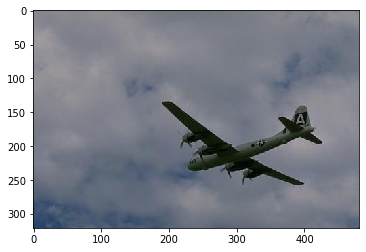

In [1713]:
data_plane = preprocess_image('3096_color.jpg', True).reshape(-1,5)

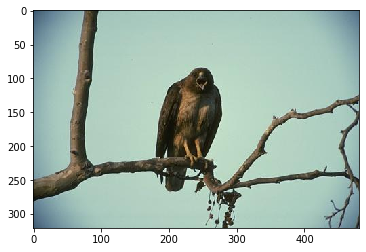

In [1714]:
data_bird = preprocess_image('42049_color.jpg', True).reshape(-1,5) # (154401, 5)

## GMM parameter estimation by EM

In [2023]:
class GMM_PS(object):
    def __init__(self, m0s, c0s, weights):
        self.init_cache = (m0s, c0s, weights)
        
    @classmethod
    def get_gaussian(cls, data, mu, c):
        n = mu.shape[0]
        inv_c = np.linalg.inv(c)
        constant = 1 / ((2*np.pi)**(n/2) * np.linalg.det(c) ** (1/2))
        
        part1 = np.einsum('nx, xy -> ny', data - mu.T, inv_c)
        power = np.einsum('ny, ny -> n', part1, data - mu.T)
        return constant * np.exp(-0.5 * power) # shape(n,)
    
    @classmethod
    def get_log_gaussian(cls, data, mu, c):
        n = mu.shape[0]
        inv_c = np.linalg.inv(c)
        constant = 1 / ((2*np.pi)**(n/2) * np.linalg.det(c) ** (1/2))
        
        part1 = np.einsum('nx, xy -> ny', data - mu.T, inv_c)
        power = np.einsum('ny, ny -> n', part1, data - mu.T)
        return np.log(constant) - 0.5 * power # shape(n,)
    
    @classmethod
    def calc_expectation_cache(cls, data, current_cache):
        m0s, c0s, weights = current_cache
        
        # Li0: shape [n,]
        gmm_Ls = [w * cls.get_gaussian(data, m, c) for w,m,c in zip(weights, m0s, c0s)] #shape(n,)
        Li0 = np.sum(gmm_Ls, axis=0)
        
        # wik: shape [n,k]
        wik = (gmm_Ls / Li0).T
        
        return wik 
    
    @classmethod
    def update_c(cls, data, m, weights):
        part1 = np.einsum('nx,ny->nxy', data - m, data - m)
        return np.einsum('n, nxy->xy', weights, part1) / weights.sum() 
    
    @classmethod
    def update(cls, data, current_cache, exp_cache):
        m0s, c0s, weights = current_cache
        wik = exp_cache
         
        pk = wik.sum(axis=0) / wik.shape[0] 
        m_weight = wik.T # [k,n]
        m0s_new = np.einsum('nk,nd -> kd', wik, data) / np.sum(wik,axis=0)[...,np.newaxis] #[k,d]
        c0s_new = [cls.update_c(data, mk, wk) for mk,wk in zip(m0s_new, m_weight)] 
        return m0s_new, c0s_new, pk
    
    @classmethod
    def calc_Q(cls, data, current_cache, exp_cache):
        m0s, c0s, weights = current_cache
        wik = exp_cache
        
        #part_temp = [cls.get_gaussian(data, mk, ck) * wk 
        #             for mk,ck,wk in zip(m0s,c0s,weights)]
        #print(part_temp)
        log_part = [cls.get_log_gaussian(data, mk, ck) * wk 
                    for mk,ck,wk in zip(m0s,c0s,weights)]
        
        m_weight = wik.T #[k,n]
        part_0 = (log_part * m_weight).sum()
        return part_0 
        
    def __call__(self, data, criteria=0.25, max_iter=1000):
        Q_list = list()
        init_exp_cache = self.calc_expectation_cache(data, self.init_cache)
        current_cache = self.update(data, self.init_cache, init_exp_cache)
        
        init_Q = self.calc_Q(data, self.init_cache, init_exp_cache)
        Q_list.append(init_Q)
        i = 0
        while True:
            exp_cache = self.calc_expectation_cache(data, current_cache)
            new_cache = self.update(data, current_cache, exp_cache)
            Q = self.calc_Q(data, new_cache, exp_cache)
            Q_list.append(Q)
            current_cache = new_cache
            i += 1
            
            if np.abs(Q - Q_list[-2]) < criteria:
                break
            if i > max_iter:
                break

        return Q_list, new_cache

## MAP classifier

In [1525]:
class MAPclf(object):
    def __init__(self, mus, sigmas):
        n = len(mus[0])
        sigmas_inv = []
        constants = []
        for i in range(len(mus)):
            sigmas_inv.append(np.linalg.inv(sigmas[i]))
            constants.append(1 / ((2*np.pi)**(n/2) * np.linalg.det(sigmas[i]) ** (1/2)))
      
        self.cache = (mus,sigmas,sigmas_inv,constants)
                     
    def get_gaussian(self,data, constant, mu, inv_c):
        part1 = np.einsum('nx, xy -> ny', data - mu.T, inv_c)
        power = np.einsum('ny, ny -> n', part1, data - mu.T)
        return constant * np.exp(-0.5 * power)
        
    def __call__(self, data, pks):   
        
        (mus,sigmas,sigmas_inv,constants) = self.cache
        
        likelihoods = []
        for i in range(len(pks)):
            likelihoods.append(self.get_gaussian(data, constants[i], mus[i], sigmas_inv[i]) * pks[i])
        
        return np.argmax(likelihoods, axis = 0)


## Segmentation with 2-components GMM

In [2010]:
gmm_2 = mixture.GaussianMixture(2)

In [2012]:
plane_pred_2 = gmm_2.fit_predict(data_plane).reshape(im1.shape[:2])

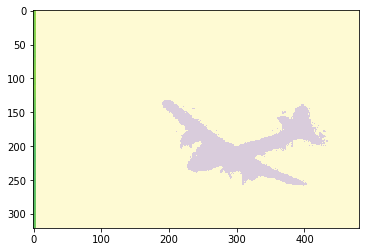

In [2014]:
plt.imshow(data_plane[...,2:])
color_dict = {0: 'salmon', 1: 'lime'}
plt.imshow(plane_pred_2, alpha=0.2)

In [2019]:
bird_pred_2 = gmm_2.fit_predict(data_bird).reshape(im1.shape[:2])

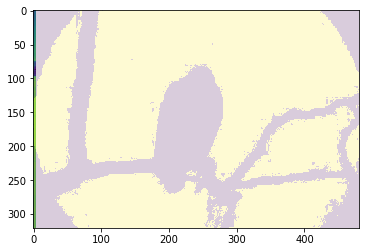

In [2000]:
plt.imshow(data_bird[...,2:])
color_dict = {0: 'salmon', 1: 'lime'}
plt.imshow(bird_pred_2, alpha=0.2)

## Segmentation with 3-components GMM

In [2016]:
gmm_3 = mixture.GaussianMixture(3)

In [2017]:
plane_pred_3 = gmm_3.fit_predict(data_plane).reshape(im1.shape[:2])

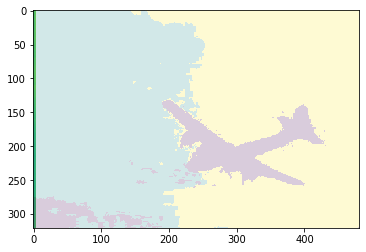

In [2018]:
plt.imshow(data_plane[...,2:])
color_dict = {0: 'salmon', 1: 'lime'}
plt.imshow(plane_pred_3, alpha=0.2)

In [2020]:
bird_pred_3 = gmm_3.fit_predict(data_bird).reshape(im1.shape[:2])

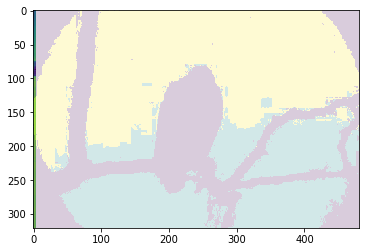

In [2021]:
plt.imshow(data_bird[...,2:])
color_dict = {0: 'salmon', 1: 'lime'}
plt.imshow(bird_pred_3, alpha=0.2)

## Choose the best number of components

In [1961]:
def k_fold_EM(dataset, k):
    data_size = len(dataset)
    step = data_size // k
    index = np.arange(k) * step
    for i in range(k):
        val_index = np.arange(index[i], index[i] + step)
        train_index = list(set(range(data_size)).difference(val_index))
        yield dataset[train_index], dataset[val_index]

In [2065]:
def select_best_number_components(data):
    data_kfold = [(train, val, i) for i,(train, val) in enumerate(k_fold_EM(data,10))]
    GMM_clustering_result = {}
    for num_node in range(1,6):
        data_kfold = [(train, val, i) for i,(train, val) in enumerate(k_fold_EM(data,10))]
        score_list = []
        for j in range(0,10):
            train_data = data_kfold[j][0]
            val_data = data_kfold[j][1]
            
            model = mixture.GaussianMixture(num_node)
            fit_model = model.fit(train_data)
            log_likelihood = fit_model.score(val_data)
            score_list.append(log_likelihood)
        GMM_clustering_result[num_node] = score_list
    return GMM_clustering_result        

In [2066]:
plane_select_result = select_best_number_components(data_plane)

In [2067]:
bird_select_result = select_best_number_components(data_bird)

In [2069]:
def calculate_average_score(result):
    avg_score = []
    for i in range(1,6):
        avg_score.append(np.array(result[i]).mean())
    return avg_score

In [2070]:
avg_score_plane = calculate_average_score(plane_select_result)

In [2071]:
avg_score_bird = calculate_average_score(bird_select_result)

In [2072]:
selected_best_number_plane = np.array(avg_score_plane).argmax()+1

In [2073]:
selected_best_number_bird = np.array(avg_score_bird).argmax()+1

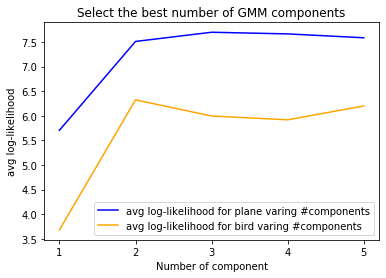

In [2074]:
plt.plot(range(1,6),avg_score_plane,c = 'blue',label = 'avg log-likelihood for plane varing #components')
plt.plot(range(1,6),avg_score_bird,c = 'orange', label = 'avg log-likelihood for bird varing #components')
plt.xlabel('Number of component')
plt.ylabel('avg log-likelihood')
plt.title('Select the best number of GMM components')
plt.xticks(np.arange(1, 6, 1))
plt.legend()